In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
np.random.seed(41)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [3]:
def plot_convex_hull(points, hull):
    """
    Plots the convex hull of a set of points in 2D.

    Parameters:
    points (array-like): An array of shape (n, 2) where n is the number of points.
    """
    # Convert points to a numpy array
    points = np.array(points)

    # Plot the convex hull simplices
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    # Plot the points
    plt.plot(points[:, 0], points[:, 1], "o", label="Points")
    plt.plot(
        points[hull.vertices[:], 0],
        points[hull.vertices[:], 1],
        "o",
        c="r",
        label="Hull Vertices",
    )
    plt.rcParams["figure.figsize"] = (10, 6)

    plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], alpha=0.3, label='Convex Hull')

    # plt.title('Convex Hull of Points')
    # plt.xlabel('X-axis')
    # plt.ylabel('Y-axis')
    plt.legend(loc="upper left")
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    # plt.grid()
    return plt

In [4]:
def hull_extensions(X, t):
	"""
	Calculates the directions of the convex hull's extents in 2D.
	"""
	directions = np.array([np.array([np.cos(theta), np.sin(theta)]) for theta in np.linspace(0, 2 * np.pi, t)])
	extents = dict({})
	extents_max = dict({})
	for x in X:
		extents[tuple(x)] = []
		extents_max[tuple(x)] = (None, -1)

	dot_products = np.dot(X, directions.T)
	for i, direction in enumerate(directions):
		x = X[np.argmax(dot_products[:, i])]
		extents[tuple(x)].append(direction)
		if extents_max[tuple(x)][1] < dot_products[np.argmax(dot_products[:, i]), i]:
			extents_max[tuple(x)] = (direction, dot_products[np.argmax(dot_products[:, i]), i])

	random_directions = np.random.normal(size=(50, 2))
	random_directions /= np.linalg.norm(random_directions, axis=1)[:, np.newaxis]
	random_extents = dict({})
	for x in X:
		random_extents[tuple(x)] = []
	random_dot_products = np.dot(X, random_directions.T)
	for i, random_directions in enumerate(random_directions):
		x = X[np.argmax(random_dot_products[:, i])]
		random_extents[tuple(x)].append(random_directions)
	return extents, random_extents, extents_max


(50, 2)


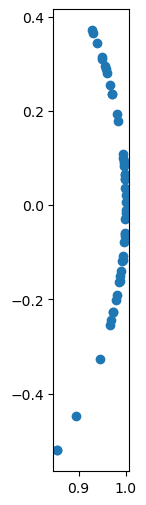

In [ ]:
def MVEE(points, tol=0.001):
    """
    Finds the minimum volume enclosing ellipsoid (MVEE) of a set of points.
    Uses Khachiyan's algorithm.
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T

    u = np.ones(N) / N
    err = 1 + tol

    while err > tol:
        X = Q @ np.diag(u) @ Q.T
        M = np.diag(Q.T @ np.linalg.inv(X) @ Q)
        j = np.argmax(M)
        step_size = (M[j] - d - 1) / ((d + 1) * (M[j] - 1))
        new_u = (1 - step_size) * u
        new_u[j] += step_size
        err = np.linalg.norm(new_u - u)
        u = new_u

    center = u @ points
    A = np.linalg.inv(points.T @ np.diag(u) @ points - np.outer(center, center)) / d

    return center, A

import numpy as np


def _sample_weight(kappa, d):
    # Ulrich’s method constants
    b = (-2 * kappa + np.sqrt(4 * kappa**2 + (d - 1) ** 2)) / (d - 1)
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + (d - 1) * np.log(1 - x0**2)

    while True:
        # Beta-sample step
        Z = np.random.beta((d - 1) / 2, (d - 1) / 2)
        W = (1 - (1 + b) * Z) / (1 - (1 - b) * Z)
        # Uniform for acceptance
        U = np.random.rand()
        if kappa * W + (d - 1) * np.log(1 - x0 * W) - c >= np.log(U):
            return W


def sample_vMF(m, d, kappa):
    # Step 1: sample W = component along e1
    W = np.array([_sample_weight(kappa, d) for _ in range(m)])
    # Step 2: sample (d-1)-dim isotropic Gaussian and normalize
    V = np.random.normal(size=(m, d - 1))
    V /= np.linalg.norm(V, axis=1, keepdims=True)
    # Step 3: build samples
    samples = np.zeros((m, d))
    samples[:, 0] = W
    # embed the (d-1)-dim orthonormal part
    samples[:, 1:] = np.sqrt(1 - W**2)[:, None] * V
    return samples

def householder_matrix(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Compute the Householder reflection H (d×d) such that H @ a = b,
    where a and b are assumed to be unit vectors in R^d.
    """
    v = a - b
    v = v / np.linalg.norm(v)
    H = np.eye(a.shape[0]) - 2.0 * np.outer(v, v)
    return H


def extents_estimation(P: np.ndarray, U: np.ndarray, E: np.ndarray) -> np.ndarray:
    """
    Implements the “Extents Estimation” subroutine.
    Inputs:
      P : (n,d) array of input points in R^d
      U : (m,d) array of sampled directions on S^{d-1}
      E : (k,d) array of extremal points from MVEE(P)
    Returns:
      S : an array of the selected subset of P (shape ≤ n×d)
    """
    n, d = P.shape
    # unit basis e1 = [1,0,...,0]
    e1 = np.zeros(d)
    e1[0] = 1.0

    S_indices = set()

    # for each original point
    for i in range(n):
        p = P[i]

        # 1) find the closest MVEE point
        j_star = np.argmin(np.linalg.norm(E - p, axis=1))
        p_hat = E[j_star]

        # 2) build the rotation/reflection sending e1 → p_hat
        R = householder_matrix(e1, p_hat)

        # 3) rotate all directions in U
        U_rot = U @ R.T  # still shape (m,d)

        # 4) for each rotated direction, pick the supporting point in P
        #    (i.e. max dot with that direction)
        for u in U_rot:
            # compute dot products
            dots = P.dot(u)
            s_idx = int(np.argmax(dots))
            S_indices.add(s_idx)

    # assemble S as the unique selected points
    S = P[list(S_indices), :]
    return S


def convex_hull_via_mvee(P: np.ndarray, m: int, kappa: float) -> np.ndarray:
    """
    Top-level: sample m directions from vMF, compute MVEE, then
    run the extents-estimation to get a small hull subset S.
    """
    n, d = P.shape

    # 1) sample m directions on the sphere with concentration kappa
    U = sample_vMF(m, d, kappa)  # → (m,d)

    # 2) compute MVEE of P
    E = MVEE(P)  # → (k,d)

    # 3) find the “extreme” subset
    S = extents_estimation(P, U, E)
    return S


def hull_extension_MVEE(X, t):
    """
    Calculates the directions of the convex hull's extents in 2D using the Minimum Volume Enclosing Ellipsoid (MVEE) method.
    """
    mvee = MVEE(X)
    Y = sample_vMF(t, 2, kappa=20)

# suppose P is an (n,d) array of your data points
# e.g. n=1000, d=5
P = np.random.randn(30, 2)

# choose number of sampled directions and concentration
m = 20
kappa = 10.0  # higher → more tightly around e1

# run
S = convex_hull_via_mvee(P, m, kappa)



In [6]:
def plot_convex_hull_extents(points, hull, t, plot_extents=True):
    """
	Plots the convex hull and its extents.

	Parameters:
	points (array-like): An array of shape (n, 2) where n is the number of points.
	"""
    plt = plot_convex_hull(points, hull)
    extents, rex, mx = hull_extensions(points, t)

    for point, directions in extents.items():
        for direction in directions:
            plt.arrow(point[0], point[1], direction[0], direction[1], 
				head_width=0, head_length=0, fc='b', ec='b', alpha=0.02)

    if(plot_extents==True):
        for point, directions in rex.items():
            for direction in directions:
                plt.arrow(point[0], point[1], direction[0], direction[1], 
					head_width=0.1, head_length=0.2, fc='r', ec='r', alpha=0.2)

    # for point, _max in mx.items():
    # 	direction = _max[0]
    # 	if direction is None:
    # 		continue
    # 	plt.arrow(point[0], point[1], direction[0]*1.2, direction[1]*1.2,
    # 		head_width=0.1, head_length=0.2, fc='g', ec='g', alpha=0.7)

    return plt

In [7]:
def plot_all(X, plot_extents=True):
    X = np.array(X)
    hull = ConvexHull(X)
    plt = plot_convex_hull_extents(X, hull, 1000, plot_extents)
    plt.show()

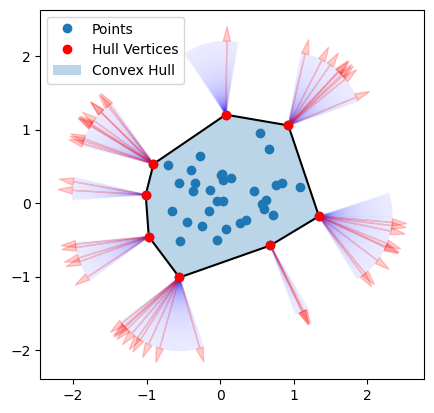

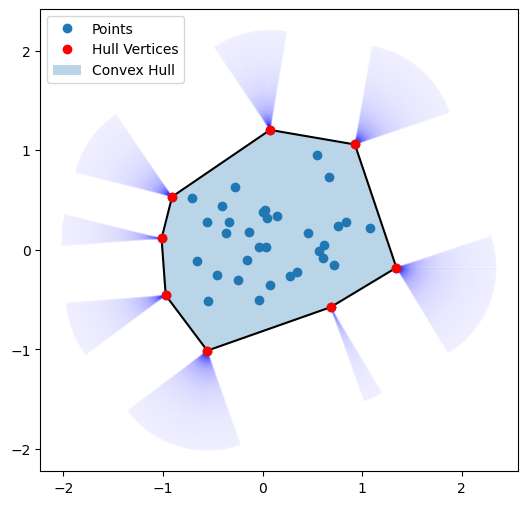

In [8]:
Z = [(0,1), (6,0), (8,0), (9,1), (8,2), (4,2), (4*0.8, 2*0.8+1*0.2)]
# _Z = np.random.normal(loc=(6, 1), scale=0.4, size=(30, 2))
_Z = np.random.normal(loc=(0, 0), scale=0.5, size=(40, 2))
Z = np.concatenate((Z, _Z), axis=0)
# plot_all(Z)
plot_all(_Z)
plot_all(_Z, False)